In [1]:
from src.data.store_data import StoreData
from src.model.gpt3_model import GPT3Model


# Use GPT to forecast sales volumes from public dataset

# Load Data

In [2]:
data_location = '/archive 2/train_0irEZ2H.csv'
store_data = StoreData(data_location)

In [3]:
store_data.data

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


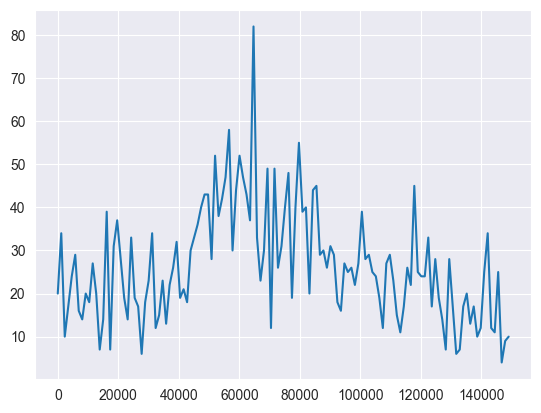

In [4]:
store_data.plot_products(product_id=216418, store_id=8091)

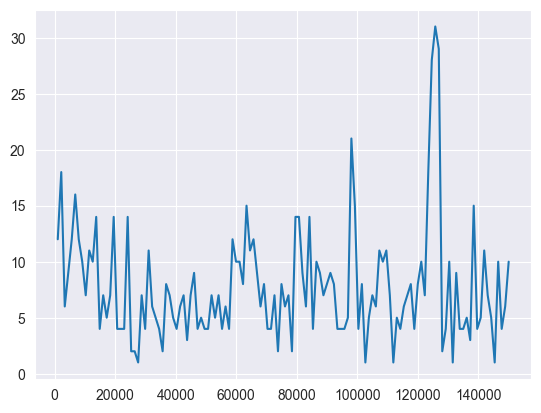

In [5]:
store_data.plot_products(product_id=320485, store_id=9876)


# Make Forecast

In [6]:
from src.preprocessing.scaler import QuantileScaler
from sklearn.preprocessing import StandardScaler

In [7]:
hist_prompt = store_data.get_data(product_ids=216418, store_ids=8091)

In [8]:
#scaler = QuantileScaler()
#scaler = StandardScaler()
scaler = None
model = GPT3Model(scaler=scaler)

In [ ]:
forecast = model.predict(hist_prompt['units_sold'].values)
forecast

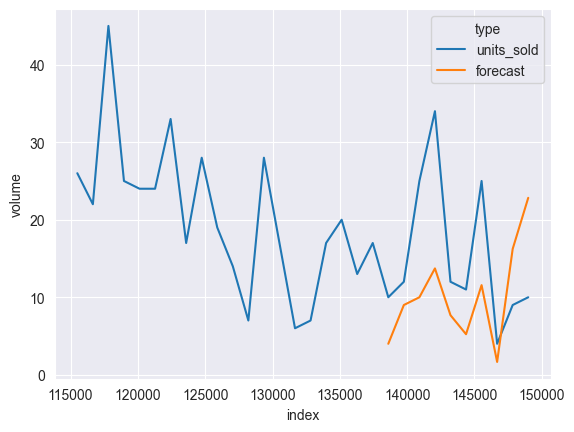

In [18]:
store_data.plot_forecast(product_id=216418, store_id=8091, forecast=forecast[0], show_from=100)

# Show Similarities

In [19]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [23]:
stores = [8091, 8095, 8094, 8063, 8023, 8058, 8222]
products = [216418, 223245]
series_embeddings = []

for store in stores:
    for product in products:
        data = store_data.get_data(product_ids=product, store_ids=store)
        series_embeddings.append(model.embed(data))

<Axes: xlabel='x', ylabel='y'>

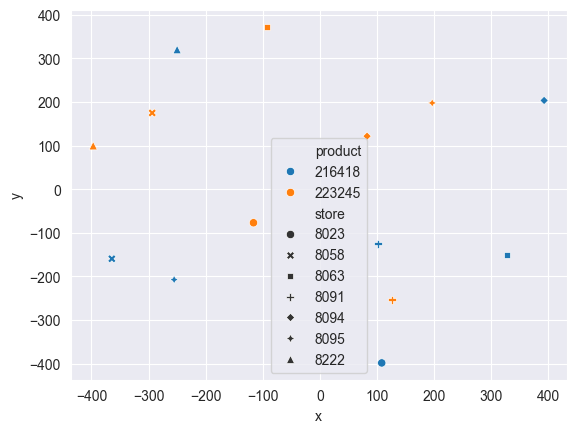

In [24]:
matrix = np.array(series_embeddings)
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

embed_df = pd.DataFrame(vis_dims, columns=['x', 'y'])
embed_df['store'] = np.repeat(stores, 2)
embed_df['product'] = np.tile(products, 7)

sns.scatterplot(data=embed_df, x='x', y='y', hue='product', style='store', palette='tab10')


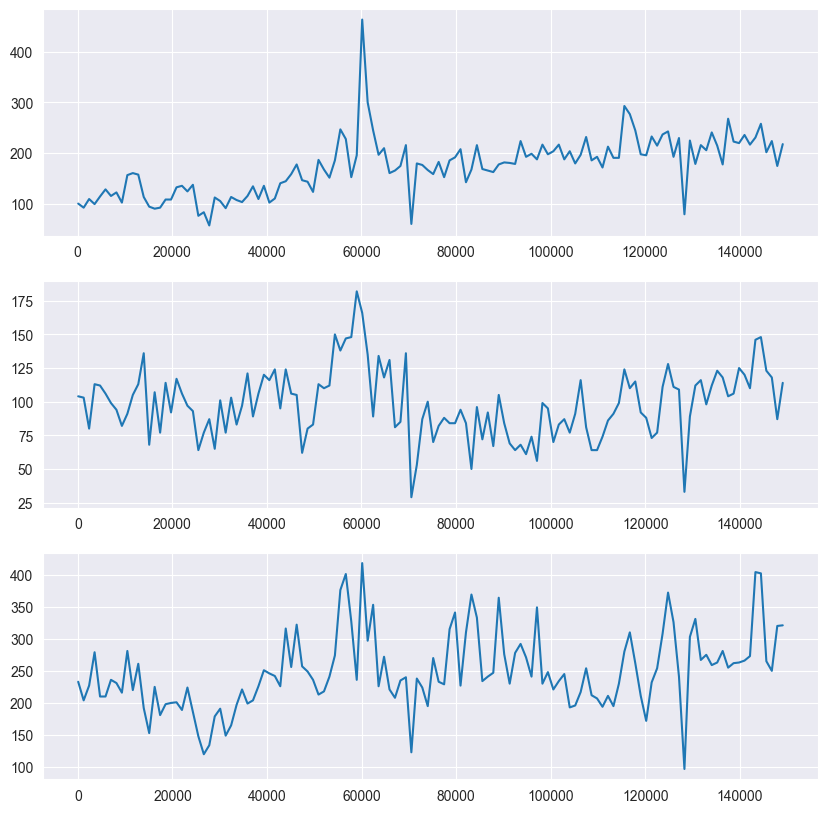

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

store_data.plot_products(product_id=216418, store_id=8222, ax=axs[0])
store_data.plot_products(product_id=216418, store_id=8058, ax=axs[1])
store_data.plot_products(product_id=216418, store_id=8023, ax=axs[2])

# Interpret Volumes

In [23]:
d1 = store_data.get_serialized_data(product_id=216418, store_id=8222)
d2 = store_data.get_serialized_data(product_id=216418, store_id=8058)

In [28]:
chatgpt_sys_message = (f"You're giving similar time series of sales volumes. The user will provide two sequences of historic sales volumes . The different volumes are separated by commas."
                       f"Explain why the two sequences are similar. For this, separate the series into relvent parts and explain why they are similar. For example, you can say that the two sequences are similar because they both have higher sales volume from point x to point y with a mean of z, comparing to the time before and after with a mean of z2. When you describe extreme values or outliers, state the time point and the value.")
extra_input = (f"Sequence One: {d1.replace(' ', '').replace(',', ', ')}\n Sequence Two: {d2.replace(' ', '').replace(',', ', ')}\n")

completion = model.client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": chatgpt_sys_message},
        {"role": "user", "content": extra_input}
    ]
)

In [29]:
completion.choices[0].message.content   

'The two sequences of sales volumes are similar because they both exhibit similar patterns over time. \n\nIn both sequences, there are fluctuations in sales volumes, with some periods of higher sales and some periods of lower sales. The highest sales volume in Sequence One occurs at time point 50 with a value of 463, while the highest sales volume in Sequence Two occurs at time point 53 with a value of 182. These extreme values indicate peak sales periods in both sequences. \n\nFurthermore, both sequences have periods of relatively higher sales volumes. In Sequence One, there is a notable increase in sales volume from point 9 to point 12, with a mean of approximately 160. Similarly, in Sequence Two, there is a rise in sales volume from point 11 to point 14, with a mean of around 115. \n\nAdditionally, both sequences have lower sales volumes during specific time periods. In Sequence One, there is a decrease in sales volume from point 23 to point 26, with a mean of approximately 79. In S

# Rare Events

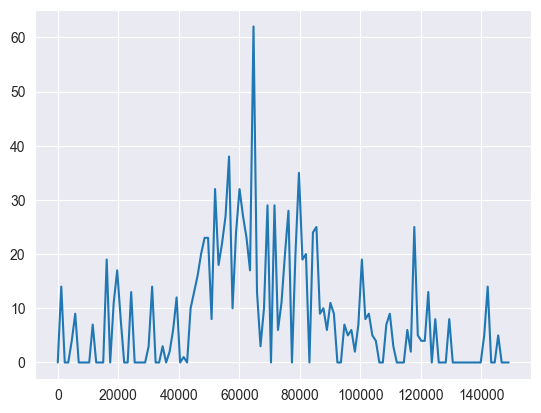

In [67]:
store_data.plot_products(product_id=216418, store_id=8091)


In [66]:
# Remove all sales lower than 20 to simulate a rare event
t = store_data.data[(store_data.data['sku_id'] == 216418) & (store_data.data['store_id'] == 8091)][ 'units_sold'].apply(lambda x: max(0, x - 20)).values
store_data.data.loc[(store_data.data['sku_id'] == 216418) & (store_data.data['store_id'] == 8091), 'units_sold'] = t

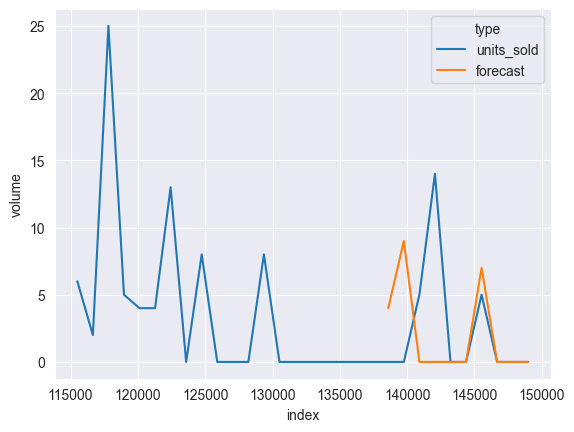

In [68]:
# Rare events are also forecasted well
hist_prompt = store_data.get_serialized_data(product_id=216418, store_id=8091)
forecast = model.predict(hist_prompt)
store_data.plot_forecast(product_id=216418, store_id=8091, forecast=forecast[0], show_from=100)